In [2]:
import sys
sys.path.append('/home1/jrudoler/src/')
# normal python
import warnings
warnings.simplefilter('ignore')
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
import scipy as scp
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.labelsize'] = 16
import seaborn as sns

# ML stuff
from classifier_io import ClassifierModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn import __version__ as sklearn_version
from sklearn.utils import parallel_backend
from sklearn.metrics import roc_auc_score, roc_curve
from statsmodels.stats.multitest import fdrcorrection
from joblib.parallel import Parallel, delayed

# lab things
import cmlreaders as cml
from pd_to_pb import pandas_to_pybeh as pb
# from ptsa.data.filters import MorletWaveletFilter, ButterworthFilter
from ptsa.data.timeseries import TimeSeries
from ptsa.data.concat import concat
sns.set_palette('twilight')
from dask.distributed import Client, progress
import cmldask.CMLDask as da
from nicls_helpers import *

def post_hoc_permutation(y_true, y_score, n_permutations=4999, score_function=roc_auc_score, seed=None, n_jobs=None, backend="threading", verbose=False): 
    if seed:
        np.random.seed(seed)
    score = score_function(y_true, y_score)
    permutation_scores = Parallel(n_jobs=n_jobs, backend=backend, verbose=verbose)(
        delayed(score_function)(
            np.random.choice(y_true, len(y_true), replace=False),
            y_score
        )
        for _ in range(n_permutations)
    )
    permutation_scores = np.array(permutation_scores)
    pvalue = (np.sum(permutation_scores >= score) + 1.) / (n_permutations + 1.)
    return score, permutation_scores, pvalue 

def post_hoc_permutation_cv(y_true, y_pred, cv):
    holdout_sets = [test for _, test in cv.split(y_true)]
    all_score = []
    all_null = []
    for holdout_idx in holdout_sets:
        score, null, p = post_hoc_permutation(y_true[holdout_idx], y_pred[holdout_idx, 1], n_jobs=-1, verbose=True)
        all_score.append(score)
        all_null.append(null)
    score = np.mean(all_score)
    avg_null = np.vstack(all_null).mean(0)
    pvalue = (np.sum(np.mean(all_score) <= avg_null)+1.)/(all_null.shape[1]+1.)
    return score, avg_null, pvalue

Load Subjects

In [2]:
index = cml.get_data_index("ltp")

# nsessions = index.query("experiment=='NiclsCourierReadOnly'")\
# .groupby("subject").count()['task_events'].reset_index().rename(columns={"task_events":"nsessions"})
subject_list = np.loadtxt("final_subject_list.txt", dtype=str)
# subject_list = nsessions.query("nsessions>=4")['subject'].values
# subject_list = subject_list[~np.isin(subject_list, ['LTP448', 'LTP458'])] # remove subjects with bad/missing data

### Decoding memory success

In [3]:
def NestedLOGO(data, estimator, param_grid, inner_cv_group='session', outer_cv_group='session', client=None, verbose=True):
    outer_cv = LeaveOneGroupOut()
    inner_cv = LeaveOneGroupOut()
    results = {"subject": data['subject'].values[0], "holdout_session":[], "penalty":[], "AUC":[], "null":[],
               "pval":[], "fp":[], "tp":[], "y_true":[], "y_pred":[], "model":[], "activations":[]}
    ## outer cv over sessions, holding one out
    models = []
    for train_idx, test_idx in outer_cv.split(X=data.data,
                                              y=data.recalled.values,
                                              groups=data[outer_cv_group].values):
        ## inner cv fold over remaining sessions to select penalty
        inner_model = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=inner_cv.split(X=data.data[train_idx],
                              y=data.recalled.values[train_idx],
                              groups=data[inner_cv_group].values[train_idx]),
            scoring='roc_auc',
            n_jobs=1, verbose=verbose
        )
        inner_model.fit(X=data.data[train_idx], y=data.recalled.values[train_idx])
        ## automatically uses best fit from inner cv
        predictions = inner_model.predict_proba(X=data.data[test_idx])[:, 1]
        if np.mean(data.recalled.values[test_idx]) in [0., 1.]:
            auc = np.nan
            auc_null = None
            p = np.nan
            fp = None
            tp = None
        else:
            auc, auc_null, p = post_hoc_permutation(y_true=data.recalled.values[test_idx], 
                                                    y_score=predictions)
            fp, tp, _ = roc_curve(data.recalled.values[test_idx], predictions)
        # compute feature activations
        activation = compute_activation(data.data[train_idx], inner_model.best_estimator_.coef_.flatten())
        activation = activation.reshape((8, 128))
        ## update results
        results["holdout_session"].append(data.session[test_idx].values[0])
        results["y_true"].append(data.recalled.values[test_idx])
        results["y_pred"].append(predictions)
        results["AUC"].append(auc)
        results["null"].append(auc_null)
        results["penalty"].append(inner_model.best_params_['C'])
        results["pval"].append(p)
        results["fp"].append(fp)
        results["tp"].append(tp)
        results["model"].append(inner_model.best_estimator_)
        results["activations"].append(activation)
    return pd.DataFrame(results)

def compute_activation(X, weights):
    '''A = cov(X) * W / cov(y_hat)'''
    # where X = train_data.values
    
    activations = np.cov(X.T).dot(weights) / np.cov(X.dot(weights))

    # activations shape: N features array
    return activations

def load_and_fit_data_encoding(path, group):
    estimator = LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs', max_iter=1000)
    param_grid = {"C":np.power(10., -np.arange(6))}
    encoding_data = TimeSeries.from_hdf(path)
    phase = np.where(encoding_data['trial']<5, 0, 1)
    encoding_data = encoding_data.assign_coords(
        subsession=("event", encoding_data["session"].values*2+phase),
        sess_trial=("event", encoding_data["session"].values*10+encoding_data["trial"].values)
    )
    encoding_data = encoding_data.query({"event":"subsession>0 & trial>=0"})
    results = NestedLOGO(encoding_data, estimator, param_grid,
                         inner_cv_group=group, outer_cv_group=group)
    return results


def bordered_imshow(X, mask, line_kwargs={"linewidth":4, "color":'k'}, **kwargs):
    shape = X.shape
    im = plt.imshow(X, extent=[0, shape[0], 0, shape[1]], origin='lower', **kwargs)
    ax = plt.gca()
    extent = im.get_extent()
    masked_cells = [(i, j) for i, j in zip(*np.nonzero(mask))]
    for cell in masked_cells:
        # left
        if (cell[0], cell[1]-1) not in masked_cells:
            line = plt.Line2D([extent[0]+(extent[1]/shape[1])*cell[1], extent[0]+(extent[1]/shape[1])*cell[1]],
                              [extent[2]+(extent[3]/shape[0])*cell[0], extent[2]+(extent[1]/shape[0])*cell[0]+1],
                              **line_kwargs)
            ax.add_patch(line)
        # right
        if (cell[0], cell[1]+1) not in masked_cells:
            line = plt.Line2D([extent[0]+(extent[1]/shape[1])*cell[1]+1, extent[0]+(extent[1]/shape[1])*cell[1]+1],
                              [extent[2]+(extent[3]/shape[0])*cell[0], extent[2]+(extent[1]/shape[0])*cell[0]+1],
                              **line_kwargs)
            ax.add_patch(line)
        # above
        if (cell[0]+1, cell[1]) not in masked_cells:
            line = plt.Line2D([extent[0]+(extent[1]/shape[1])*cell[1], extent[0]+(extent[1]/shape[1])*cell[1]+1],
                              [extent[2]+(extent[3]/shape[0])*cell[0]+1, extent[2]+(extent[1]/shape[0])*cell[0]+1],
                              **line_kwargs)
            ax.add_patch(line)
        # below
        if (cell[0]-1, cell[1]) not in masked_cells:
            line = plt.Line2D([extent[0]+(extent[1]/shape[1])*cell[1], extent[0]+(extent[1]/shape[1])*cell[1]+1],
                              [extent[2]+(extent[3]/shape[0])*cell[0], extent[2]+(extent[1]/shape[0])*cell[0]],
                              **line_kwargs)
            ax.add_patch(line)
    return im, ax

In [4]:
### CML specific
client = da.new_dask_client_slurm(
    job_name="NICLS_classification",
    memory_per_job="5GB",
    max_n_jobs=100,
    adapt=True
)
# client.cluster.scale(30)

## set up dask client for parallel computing 
# client = Client()

Unique port for jrudoler is 51360
{'dashboard_address': ':51360'}
To view the dashboard, run: 
`ssh -fN jrudoler@rhino2.psych.upenn.edu -L 8000:192.168.86.106:51360` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [19]:
# encoding_futures = client.map(load_and_fit_data_encoding, [f"/scratch/nicls_intermediate/read_only/encoding_powers/{sub}_feats.h5" 
#                                                            for sub in subject_list], group="subsession")
encoding_futures = client.map(load_and_fit_data_encoding, [f"/scratch/nicls_cns/final_pows/{sub}_encoding_feats.h5" 
                                                           for sub in subject_list], group="subsession")

In [79]:
client.cancel(encoding_futures)

In [20]:
progress(encoding_futures)

VBox()

In [22]:
gathered_results_encoding = client.gather(encoding_futures)

In [23]:
full_results_encoding = pd.concat(gathered_results_encoding)

In [65]:
full_results_encoding.to_pickle("RO_classification_results_encoding.pkl")

In [4]:
full_results_encoding = pd.read_pickle("RO_classification_results_encoding.pkl")

### Encoding ROC

In [5]:
full_results_encoding.groupby("subject").agg({"AUC":"mean"})

,AUC
subject,
LTP462,0.539361
LTP468,0.487872
LTP470,0.570519
LTP473,0.465410
LTP474,0.496322
LTP475,0.523258
LTP476,0.540960
LTP477,0.610334
LTP478,0.458374


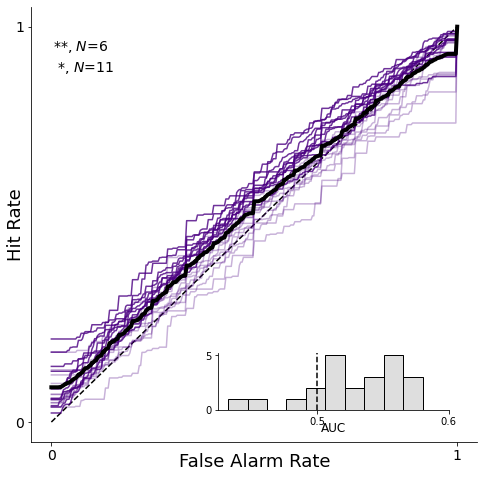

In [25]:
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject, subject_results in full_results_encoding.groupby("subject"):
#     print(subject)
    subject_tp = []
    auc = []
    auc_null = []
    for i, row in subject_results.iterrows():
        if np.mean(row["y_true"]) in [0., 1.]:
            continue
        auc.append(row["AUC"])
        auc_null.append(row["null"])
        tp = np.interp(base_fp, row['fp'], row['tp'])
        subject_tp.append(tp)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    all_subjects_auc.append(auc)
    all_subjects_null_auc.append(np.mean(auc_null))
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    encoding_signif.update({subject:p})
    if p<=0.05:
        alpha=0.8
    else:
        alpha=0.3
    tp_list.append(np.mean(subject_tp, axis=0))
    ax.plot(base_fp, np.mean(subject_tp, axis=0), color='indigo', label=f"{subject}, AUC = {row['AUC']:.3f}", alpha=alpha)

top_ax = fig.add_axes([0.45, .18, .4, .1])
auc_dist = pd.DataFrame({"subject":np.unique(full_results_encoding["subject"]), "auc":all_subjects_auc})
auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
auc_dist['signif'] = auc_dist['p']<.05
top_ax.axvline(0.5, color='k', ls='--')
sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
top_ax.grid(False)
# top_ax.set_title('AUC', fontsize=14)
top_ax.set_xticks([.5, .6])
top_ax.spines['top'].set_visible(False)
top_ax.spines['right'].set_visible(False)
top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=14)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=14)

# plt.savefig('nested_loso_encoding.pdf', dpi=200, bbox_inches='tight')

In [73]:
scp.stats.ttest_1samp(full_results_encoding.groupby("subject").agg({"AUC":"mean"}), 0.5)

Ttest_1sampResult(statistic=array([3.62828998]), pvalue=array([0.00148654]))

In [71]:
mean = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).mean()[0]
sem = full_results_encoding.groupby("subject").agg({"AUC":"mean"}).sem()[0]
print(f"mean AUC = {mean:.4f} +/- {sem:.4f} ")

mean AUC = 0.5322 +/- 0.0089 


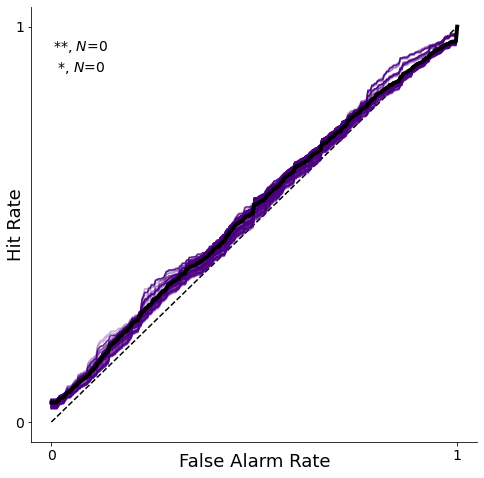

In [56]:
encoding_signif = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], '--k')
base_fp = np.linspace(0, 1, 301)
tp_list = []
all_subjects_auc = []
all_subjects_null_auc = []

for subject, subject_results in full_results_encoding.groupby("subject"):
#     print(subject)
    for i, row in subject_results.iterrows():
        if np.mean(y_true) in [0., 1.]:
            continue
#         auc.append(row["AUC"])
#         auc_null.append(row["null"])
        tp = np.interp(base_fp, row['fp'], row['tp'])
        subject_tp.append(tp)
        p = row["pval"]
        if p<=0.05:
            alpha=0.8
        else:
            alpha=0.3
        tp_list.append(np.mean(subject_tp, axis=0))
        ax.plot(base_fp, np.mean(subject_tp, axis=0), color='indigo', label=f"{subject}, AUC = {row['AUC']:.3f}", alpha=alpha)

# top_ax = fig.add_axes([0.45, .18, .4, .1])
# auc_dist = pd.DataFrame({"subject":np.unique(full_results_encoding["subject"]), "auc":all_subjects_auc})
# auc_dist['p'] = auc_dist["subject"].map(encoding_signif) 
# auc_dist['signif'] = auc_dist['p']<.05
# top_ax.axvline(0.5, color='k', ls='--')
# sns.histplot(auc_dist, x="auc", bins=10, ax=top_ax, color='lightgrey')
# top_ax.grid(False)
# # top_ax.set_title('AUC', fontsize=14)
# top_ax.set_xticks([.5, .6])
# top_ax.spines['top'].set_visible(False)
# top_ax.spines['right'].set_visible(False)
# top_ax.set_xlabel('AUC', fontsize=12, labelpad=-5)
# top_ax.set_ylabel('')    

ax.plot(base_fp, np.mean(np.vstack(tp_list), 0), color='k', lw = 4, alpha=1)
# ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1))
ax.set_ylabel('Hit Rate', fontsize=18, labelpad=-10)
ax.set_xlabel('False Alarm Rate', fontsize=18, labelpad=-10)
ax.grid(False)
ax.tick_params(labelsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

_ = ax.annotate(fr"**, $N$={sum(np.array(list(encoding_signif.values()))<=.01)}", xy=(.05, .9), xycoords="axes fraction", fontsize=14)
_ = ax.annotate(fr" *, $N$={sum(np.array(list(encoding_signif.values()))<=.05)}", xy=(.05, .85), xycoords="axes fraction", fontsize=14)

# plt.savefig('nested_loso_encoding.pdf', dpi=200, bbox_inches='tight')

### Feature Activations Encoding

In [26]:
ch_arr = np.load('channel_array.npy')
roi_dict = {
    'LAI':['C31','C32','D5','D6','D9','D10','D21','D22'],
    'LAS':['C24','C25','D2','D3','D4','D11','D12','D13'],
    'LPS':['D29','A5','A6','A7','A8','A17','A18'],
    'LPI':['D30','D31','A9','A10','A11','A15','A16'],
    'RAI':['B24','B25','B28','B29','C5','C6','C9','C10'],
    'RAS':['B30','B31','B32','C2','C3','C4','C11','C12'],
    'RPS':['A30','A31','A32','B3','B4','B5','B13'],
    'RPI':['A28','A29','B6','B7','B8','B11','B12']
}
all_activation = []
for subject, subject_results in tqdm(full_results_encoding.groupby("subject")):
#     print(subject)
    subject_activation = np.stack(subject_results['activations'])
    subject_activation = subject_activation.mean(0)
    feat_by_region = []
    for reg in roi_dict.keys():
        mask = np.isin(ch_arr, roi_dict[reg])
        reg_feats = subject_activation[:, mask].mean(1)
        feat_by_region.append(reg_feats)
    feat_by_region = np.stack(feat_by_region).T
    all_activation.append(feat_by_region)       
all_activation = np.stack(all_activation)
avg_activation = np.mean(all_activation, axis=0)

  0%|          | 0/29 [00:00<?, ?it/s]

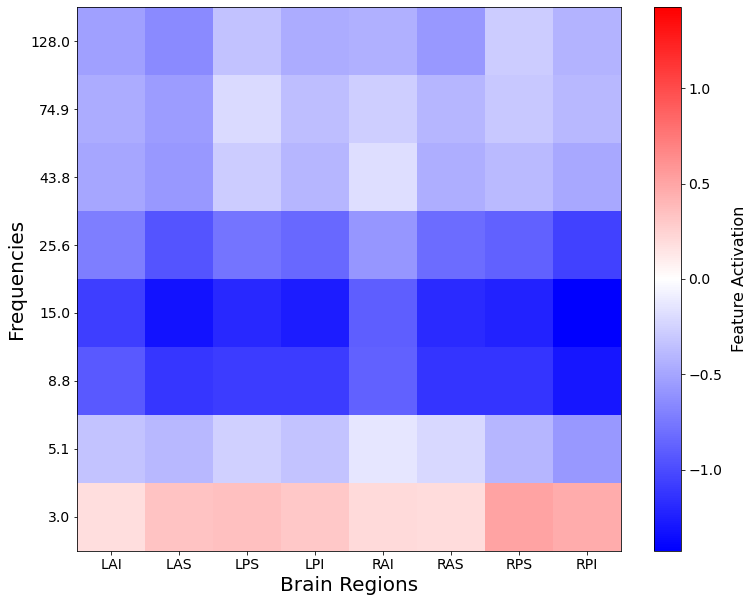

In [28]:
fig = plt.figure(figsize=(12, 10))
plt.rcParams['savefig.facecolor']='none'
mask = fdrcorrection(scp.stats.ttest_1samp(all_activation, 0)[1].ravel())[1].reshape((8, 8))<.05
im, ax = bordered_imshow(avg_activation, mask, cmap='bwr', aspect = 1, norm=CenteredNorm(0))
labels = ax.get_xticklabels()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.xlabel('Brain Regions', fontsize=20)
plt.ylabel('Frequencies', fontsize=20)
cbar = plt.colorbar(im, ax=ax, fraction = .1)
cbar.set_label(label='Feature Activation', size=16, labelpad=10)
cbar.ax.tick_params(labelsize=14)
_ = ax.set_yticks(ticks = np.arange(0.5, 8), labels=[f"{f:.1f}" for f in np.logspace(np.log10(3), np.log10(128), 8)])
_ = ax.set_xticks(ticks = np.arange(0.5, 8), labels=roi_dict.keys())
plt.savefig("NICLS_FA_loso_encoding.pdf", dpi=300, bbox_inches='tight')

## From previous notebook

In [41]:
from compute_scalp_features import compute_scalp_features

In [4]:
ro_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/NICLS/NICLS_RO_encoding_features.pkl",
                        save_path = '/scratch/nicls_intermediate/read_only/encoding_powers/')

In [36]:
cl_futures = client.map(compute_scalp_features, subject_list, 
                        settings_path = "/home1/jrudoler/NICLS/NICLS_CL_encoding_features.pkl",
                        save_path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/')

In [53]:
CL_evs["subject"].unique().shape

(21,)

In [56]:
subject_list[~np.isin(subject_list, CL_evs["subject"].unique())]

array(['LTP491', 'LTP499'], dtype='<U6')

In [ ]:
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)
settings_path = "/home1/jrudoler/NICLS/NICLS_CL_encoding_features.pkl"
save_path = "/scratch/nicls_intermediate/closed_loop/encoding_powers/"
futures = []
for subject, evs in CL_evs.query("type=='WORD'").groupby("subject"):
    fut = client.submit(compute_raw_event_features, evs, subject, settings_path, save_path)
    futures.append(fut)

### One-list normalization for closed loop

  0%|          | 0/21 [00:00<?, ?it/s]

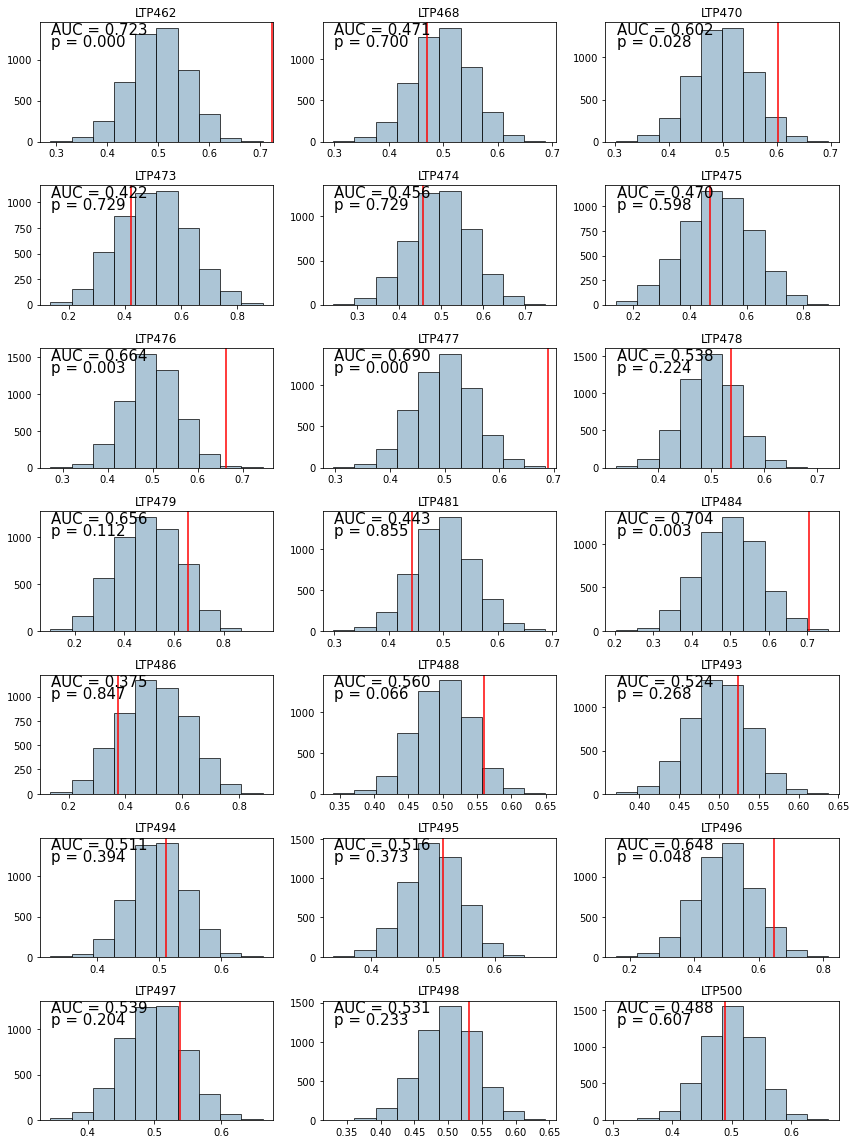

In [60]:
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'
base_fp = np.linspace(0, 1, 301)

fig, ax = plt.subplots(len(subject_list) // 3 + len(subject_list) % 3, 3, figsize=(12, 16))
ax = ax.ravel()
cl_result_dict = {}
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

session_level_results = {}

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').apply(norm_sess_feats, n_lists=1)
    
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    session_level_results[subject] = {}
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        session_level_results[subject][sess] = (score, null, p_val)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)
    
    ax[i].set_title(subject)
    ax[i].hist(auc_null, ec='k', alpha=.7)
    ax[i].axvline(auc, c='r')
    ax[i].annotate(f'p = {p:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=15)
    ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=15)
plt.tight_layout()

In [72]:
df_session_results = pd.DataFrame(session_level_results).melt(var_name="subject")
df_session_results[["score", "perm_scores", "pval"]] = df_session_results['value'].apply(pd.Series)
df_session_results = df_session_results.dropna().drop(columns=["value"])
df_session_results["session"] = df_session_results.groupby("subject").cumcount()
df_session_results

,subject,score,perm_scores,pval,session
0,LTP462,0.668527,"[0.6026785714285714, 0.6082589285714286, 0.554...",0.0134,0
1,LTP462,0.777920,"[0.5507060333761232, 0.441591784338896, 0.5661...",0.0004,1
4,LTP468,0.391148,"[0.5729665071770335, 0.5, 0.3755980861244019, ...",0.9234,0
5,LTP468,0.549941,"[0.49941245593419503, 0.4500587544065805, 0.52...",0.2508,1
8,LTP470,0.621041,"[0.4276018099547511, 0.45701357466063347, 0.60...",0.0538,0
...,...,...,...,...,...
79,LTP498,0.525000,"[0.5850000000000001, 0.52625, 0.47, 0.44500000...",0.3958,3
80,LTP500,0.587429,"[0.6068571428571428, 0.4628571428571428, 0.485...",0.1272,0
81,LTP500,0.493213,"[0.43891402714932126, 0.4705882352941177, 0.37...",0.5320,1
82,LTP500,0.289773,"[0.5511363636363636, 0.5511363636363636, 0.545...",0.9636,2


In [3]:
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)
# CL_evs = CL_evs[~(CL_evs['classifier duration']>=6)]
# drop events with intermediate wait times
# CL_evs = CL_evs[(CL_evs['wait_time']<=50)|(CL_evs['wait_time']>=5000)|(CL_evs['trial_type']=='Sham')]
# CL_evs = CL_evs[(CL_evs['wait_time']<=50)|(CL_evs['trial_type']=='Sham')]
recall_by_cond = CL_evs.query("type=='WORD' and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()
recall_by_cond

,subject,session,trial_type,recalled,probability
0,LTP462,0,Neg,0.333333,0.485012
1,LTP462,0,Pos,0.666667,0.504499
2,LTP462,0,Sham,0.300000,0.487880
3,LTP462,1,Neg,0.622222,0.485941
4,LTP462,1,Pos,0.488889,0.505100
...,...,...,...,...,...
199,LTP500,2,Pos,0.666667,0.938249
200,LTP500,2,Sham,0.600000,0.671470
201,LTP500,3,Neg,0.777778,0.174701
202,LTP500,3,Pos,0.688889,0.946089


In [ ]:
for g, df in CL_evs.groupby("subject"):
    df = df.query("type=='WORD' and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()

In [10]:
corr_df = recall_by_cond.groupby(["trial_type", "subject"], as_index=False).mean()

In [12]:
for g, df in corr_df.groupby("trial_type"):
    print(g, np.corrcoef(df["probability"], df["recalled"]))

Neg [[ 1.         -0.11058394]
 [-0.11058394  1.        ]]
Pos [[ 1.         -0.06477101]
 [-0.06477101  1.        ]]
Sham [[ 1.        -0.3125485]
 [-0.3125485  1.       ]]


In [80]:
matched_predictions = pd.read_csv("classifier_events_with_matched_predictions.csv", index_col=0)
# matched_predictions = matched_predictions[(matched_predictions['wait_time']<=50)|(matched_predictions['trial_type']=='Sham')]
matched_recall_by_cond = matched_predictions.query("matched_predictions and trial_type in ['Neg', 'Pos', 'Sham']").groupby(["subject", "session", "trial_type"]).agg({"recalled":np.nanmean, "probability":np.nanmean}).reset_index()
matched_recall_by_cond

,subject,session,trial_type,recalled,probability
0,LTP462,0,Neg,0.333333,0.482306
1,LTP462,0,Pos,0.685714,0.505035
2,LTP462,0,Sham,0.360000,0.485794
3,LTP462,1,Neg,0.571429,0.483281
4,LTP462,1,Pos,0.607143,0.505588
...,...,...,...,...,...
197,LTP500,2,Pos,0.750000,0.942167
198,LTP500,2,Sham,0.750000,0.834452
199,LTP500,3,Neg,0.766667,0.185440
200,LTP500,3,Pos,0.689655,0.987861


In [81]:
performance_stats = pd.read_csv("system_performance_stats_FR_only.csv", header=[0, 1], index_col=[0, 1])
print(f"Losing {performance_stats['bad_session'].values.sum()} sessions with bad system performance")
recall_by_cond = pd.concat([recall_by_cond.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])
matched_recall_by_cond = pd.concat([matched_recall_by_cond.groupby(["subject", "session"]).get_group(g) for g in performance_stats[~performance_stats['bad_session'].values].index])

Losing 7 sessions with bad system performance


In [86]:
scores = []
pvals = []
for i, row in recall_by_cond.iterrows():
    try:
        scores.append(df_session_results.query(f"subject=='{row['subject']}' and session=={row['session']}")["score"].values[0])
        pvals.append(df_session_results.query(f"subject=='{row['subject']}' and session=={row['session']}")["pval"].values[0])
    except IndexError:
        scores.append(None)
        pvals.append(None)
recall_by_cond["score"] = np.array(scores)
recall_by_cond["pval"] = np.array(pvals)
recall_by_cond.dropna(subset=["score", "pval"], inplace=True)
# recall_by_cond["trial_code"] = recall_by_cond["trial_type"].map({"Neg":0, "Sham":1, "Pos":2})
# recall_by_cond["signif.05"] = recall_by_cond["pval"]<=.05
# recall_by_cond["signif.1"] = recall_by_cond["pval"]<=.1
# matched_recall_by_cond["score"] = np.array(scores)
# matched_recall_by_cond["pval"] = np.array(pvals)
# matched_recall_by_cond.dropna(subset=["score", "pval"], inplace=True)

In [89]:
recall_by_cond.to_csv("memory_improvement_data.csv", index=False)
# matched_recall_by_cond.to_csv("posthoc_filtered_memory_improvement_data.csv", index=False)

## Full-session Normalization

  0%|          | 0/21 [00:00<?, ?it/s]

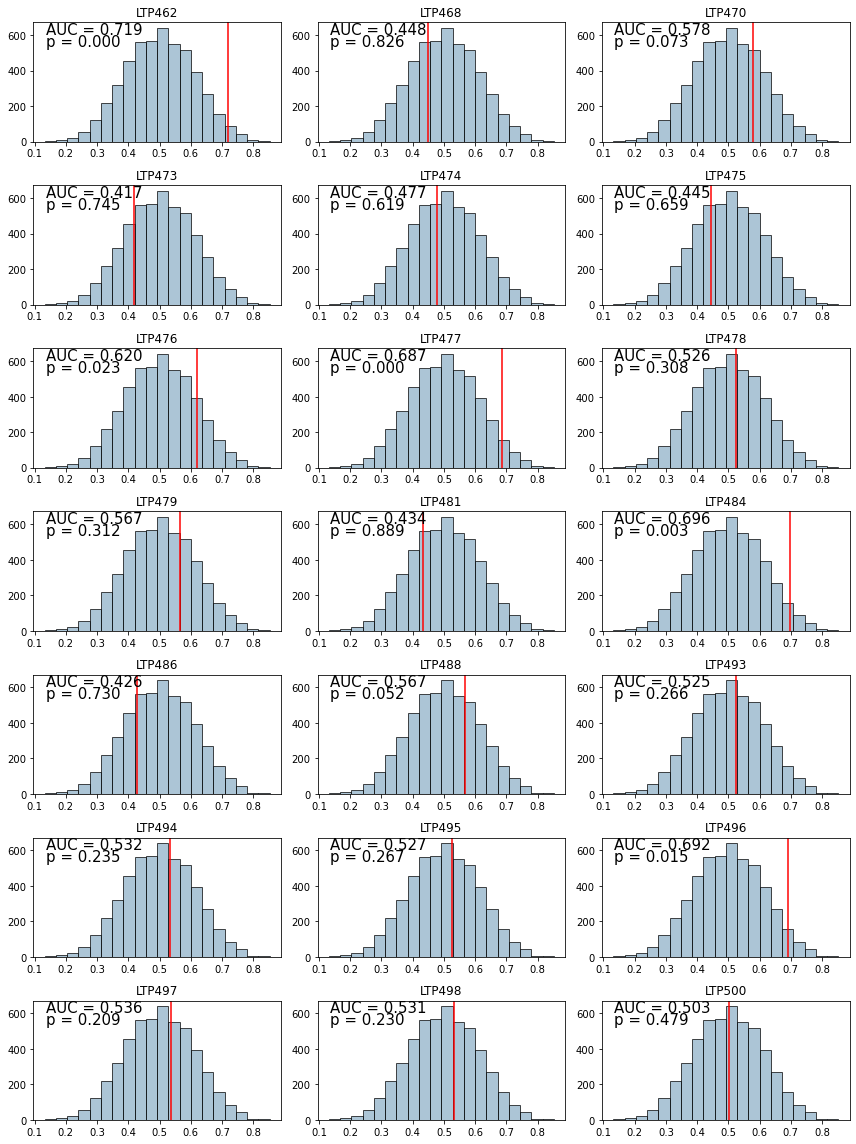

In [36]:
from scipy.stats import zscore
path = '/scratch/nicls_intermediate/closed_loop/encoding_powers/'
base_fp = np.linspace(0, 1, 301)

fig, ax = plt.subplots(len(subject_list) // 3 + len(subject_list) % 3, 3, figsize=(12, 16))
ax = ax.ravel()
cl_result_dict = {}
CL_evs = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

for i, subject in tqdm(list(enumerate(subject_list))):
    ts = TimeSeries.from_hdf(path+subject+"_raw_feats.h5", engine="netcdf4")
    evs = CL_evs.query(f'type=="WORD"&subject=="{subject}"').reset_index()
    
    ts = ts.groupby('session').reduce(func=zscore, dim='event', keep_attrs=True, ddof=1)
    
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    evs = evs.query('trial_type in ["Sham", "NoStim"]')
    sham_powers = ts.isel(event=evs.index)
    auc = []
    auc_null = []
    subject_tp = []
    for sess, sess_pows in sham_powers.groupby("session"): 
        prob = model.predict_proba(sess_pows.data)[:, 1]
        if np.mean(sess_pows.recalled.values) in [0., 1.]:
            continue
        fp, tp, _ = roc_curve(sess_pows.recalled.values, prob)
        tp = np.interp(base_fp, fp, tp)
        subject_tp.append(tp)
        score, null, p_val = post_hoc_permutation(y_true=sess_pows.recalled.values, y_score = prob)
        auc.append(score)
        auc_null.append(null)
    auc_null = np.vstack(auc_null).mean(0)
    auc = np.mean(auc)
    p_val = (np.sum(auc <= auc_null)+1.)/(len(auc_null)+1.)
    cl_result_dict[subject] = (fp, np.mean(subject_tp, axis=0), auc, auc_null)
    
    ax[i].set_title(subject)
    ax[i].hist(auc_results, ec='k', alpha=.7, bins=20)
    ax[i].axvline(auc, c='r')
    ax[i].annotate(f'p = {p_val:.3f}', xy=(.05, .8), xycoords='axes fraction', fontsize=15)
    ax[i].annotate(f'AUC = {auc:.3f}', xy=(.05, .9), xycoords='axes fraction', fontsize=15)
plt.tight_layout()

Text(0.5, 0, 'Predicted Probability')

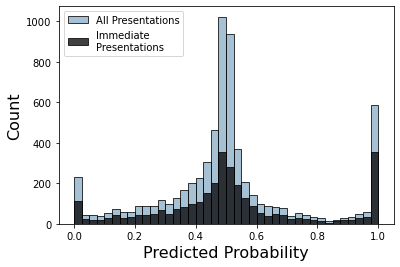

In [34]:
plt.rcParams['figure.facecolor']='white'
sns.histplot(data=CL_evs.query("type=='WORD' & trial_type!='NoStim'"), x="probability", bins=40, label='All Presentations')
sns.histplot(data=CL_evs.query("type=='WORD' & trial_type!='NoStim' & wait_time<=50"), x="probability", bins=40, color='k', label='Immediate\nPresentations')
plt.legend(loc=2)
plt.xlabel("Predicted Probability")